In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K 

import tqdm

import sys
sys.path.append('..')

import math

import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="2"

gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

## dataset read and processing

this is the same as ben's original notebook, pretty much

In [2]:
# Squirrel
features_sig=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

# Cori
# features_sig=pd.read_hdf(("/global/project/projectdirs/m3246/AnomalyDetection/LHCO/"
#                           "events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"))
# features_bg=pd.read_hdf(("/global/project/projectdirs/m3246/AnomalyDetection/LHCO/"
#                          "events_anomalydetection_DelphesPythia8_v2_qcd_features.h5"))
# features_bg2=pd.read_hdf(("/global/project/projectdirs/m3246/AnomalyDetection/LHCO/"
#                           "events_anomalydetection_DelphesHerwig_qcd_features.h5"))

In [3]:
alpha = 0.1

def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. #+ alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. #+ alpha*dataset["mjj"]
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["mjOne"] = dataset["mjOne"] + alpha*dataset["mjj"]
    dataset["mjDelta"] = dataset["mjDelta"] + alpha*dataset["mjj"]
#     dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

# column_labels = [
#     r"$m_{JJ}$",
#     r"$m^{(J_1)}$","$m^{(J_2)}$",
#     r"$\tau_{2,1}^{(J_1)}$", r"$\tau_{2,1}^{(J_2)}$"
# ]

column_labels = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
#     "$m^{J_2}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", r"$\tau_{2,1}^{J_2}$"
]


In [4]:
dataset_bg=load_data(features_bg)
# dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_bg2=load_data(features_bg2)
# dataset_bg2=np.hstack((dataset_bg2,np.zeros((len(dataset_bg2),1))))

dataset_sig=load_data(features_sig) 
# dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

## data preparation

making it machine-learnable, setting params for ML methods, setting signal significance

In [5]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
SB_low = 3.1
SB_high = 3.9
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)
def sb_crit(d):
    return ((d[:,0] < SR_low) & (d[:,0] >= SB_low)) | ((d[:,0] < SB_high) & (d[:,0] >= SR_high))

bg_sr, bg2_sr, sig_sr = sr_crit(dataset_bg), sr_crit(dataset_bg2), sr_crit(dataset_sig)
bg_sb, bg2_sb, sig_sb = sb_crit(dataset_bg), sb_crit(dataset_bg2), sb_crit(dataset_sig)

SR_background_data = dataset_bg[bg_sr]
SB_background_data = dataset_bg[bg_sb]

SR_background_sim = dataset_bg2[bg2_sr]
SB_background_sim = dataset_bg2[bg2_sb]

SR_signal = dataset_sig[sig_sr]
SB_signal = dataset_sig[sig_sb]

N_inputs = len(SR_background_data.T) - 1

# sigma = 2.00


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
#  (SR_signal, SR_signal_fortest),
#  (SB_signal, SB_signal_fortest)
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
#     SR_signal, SB_signal
]]

# Establish normalization points
mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, 
                                      SR_background_sim]), 
                      [1,99], axis=0)

def norm_func(d):
#     return (d - mn)/(mx - mn)
    return d

# Nsig = int(np.round(np.sqrt(len(SR_background_data))*sigma))
Nsig = 1000
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## Fully supervised

1-d cases are both m1 and m2

In [6]:
#First, let's do fully supervised

Nsig_each = int(len(SR_signal)/2)

SR_sig_draw = np.random.permutation(SR_signal)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

if not os.path.exists('models/supervised/'):
    os.makedirs('models/supervised/')
model_sup.save('models/supervised/model_0')

scores_sup = model_sup.predict(X_sup_val,batch_size=10*batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

In [7]:
import tqdm
#### M J2

tpr_fpr_sup_1d = []

for i in tqdm.tqdm(range(4)):
#     print('Training variable', i)
    
    K.clear_session()
    model_sup1d = Sequential()
    model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(1, activation='sigmoid'))
    model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sup = model_sup1d.fit(X_sup_train[:,i], Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

    this_scores_sup1d = model_sup1d.predict(X_sup_val[:,i],batch_size=10*batch_size)
    this_fpr_sup1d, this_tpr_sup1d, _ = roc_curve(Y_sup_val, this_scores_sup1d)
    tpr_fpr_sup_1d.append([this_tpr_sup1d, this_fpr_sup1d])
    del model_sup1d

100%|██████████| 4/4 [02:58<00:00, 44.58s/it]


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


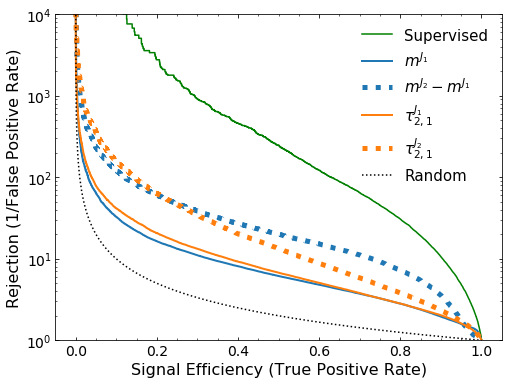

In [8]:
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
lss = ['-', ':', '-', ':']
lww = [2, 5, 2, 5]
for i,(label,(tpr,fpr)) in enumerate(zip(column_labels[1:], tpr_fpr_sup_1d)):
    
    plt.plot(tpr,1./fpr,label=label, ls=lss[i], color=colors[i], linewidth=lww[i]) #color='green',ls=":",linewidth=5)
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.savefig('plots/lhco/supervised_deltamj.pdf', bbox_inches='tight')
plt.savefig('plots/lhco/supervised_deltamj.png', bbox_inches='tight')

# SALAD

In [ ]:
#Next is SALAD
SALAD_rocs = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]
    signal_to_test = signals_to_test[i]
    
    n_data_sb = len(SB_background_sim) - len(SB_signal_to_inject)
    n_data_sr = len(SR_background_sim) - len(SR_signal_to_inject)

    if n_data_sb > len(SB_background_data):
        X_SALAD_sb_train = np.concatenate([SB_background_sim, SB_background_data,
                                           SB_background_data[np.random.choice(len(SB_background_data), 
                                                                               n_data_sb - len(SB_background_data), 
                                                                               replace=False)], 
                                           SB_signal_to_inject])
    else:
        X_SALAD_sb_train = np.concatenate([SB_background_sim, 
                                           SB_background_data[np.random.choice(len(SB_background_data), 
                                                                               n_data_sb, replace=False)], 
                                           SB_signal_to_inject])
    Y_SALAD_sb_train = np.concatenate([np.zeros(len(SB_background_sim)), np.ones(n_data_sb), 
                                       np.ones(len(SB_signal_to_inject))])
    
    sbmjj = X_SALAD_sb_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

    X_SALAD_sb_train = X_SALAD_sb_train[sb_crit]
    Y_SALAD_sb_train = Y_SALAD_sb_train[sb_crit]
    
    N_sb_low = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] <= SR_low).sum()    
    N_sb_high = (X_SALAD_sb_train[Y_SALAD_sb_train == 1][:,0] >= SR_high).sum()    
    w_low = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] <= SR_low).sum() + N_sb_low)
    w_high = 0.5*(len(SR_signal_to_inject) + n_data_sr)/((SB_signal_to_inject[:,0] >= SR_high).sum() + N_sb_high)
    
    W_SALAD_sb_train = np.ones_like(Y_SALAD_sb_train)
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]<=SR_low] *= w_low
    W_SALAD_sb_train[X_SALAD_sb_train[:,0]>=SR_high] *= w_high
    
    X_SALAD_sr_train = np.concatenate([SR_signal_to_inject, SR_background_sim, 
                                       SR_background_data[np.random.choice(len(SR_background_data), 
                                                                           n_data_sr, replace=False)]])
    Y_SALAD_sr_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.zeros(len(SR_background_sim)), 
                                       np.ones(n_data_sr)])
    
    X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train = shuffle(X_SALAD_sb_train, Y_SALAD_sb_train, 
                                                                   W_SALAD_sb_train)
    X_SALAD_sr_train, Y_SALAD_sr_train = shuffle(X_SALAD_sr_train, Y_SALAD_sr_train)
    
    X_SALAD_val = np.concatenate([signal_to_test, SR_background_data_fortest])
    Y_SALAD_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_SALAD_sb = Sequential()
    model_SALAD_sb.add(Dense(64, input_dim=N_inputs + 1, activation='relu')) 
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(1, activation='sigmoid'))
    model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

    hist_SALAD_sb = model_SALAD_sb.fit(
        X_SALAD_sb_train, Y_SALAD_sb_train, epochs=EPOCHS,
        batch_size=batch_size,#int(0.1*len(X_SALAD_sb_train)), 
        verbose=0, sample_weight=W_SALAD_sb_train
    )

    def get_weights(data, model):
        yhat = model.predict(data, batch_size=int(0.1*len(data)))
        return np.squeeze(yhat/(1 - yhat))

    # apply weight function
    W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
    W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(norm_func(X_SALAD_sr_train)[Y_SALAD_sr_train == 0], model_SALAD_sb)

    # run discriminating model
    model_SALAD_sr = Sequential()
    model_SALAD_sr.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(1, activation='sigmoid'))
    model_SALAD_sr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_SALAD_sr = model_SALAD_sr.fit(
        norm_func(X_SALAD_sr_train)[:, 1:], Y_SALAD_sr_train, epochs=EPOCHS,
        batch_size=batch_size, verbose=0,
        sample_weight=W_SALAD_sr_train
    )
    
    if not os.path.exists('models/SALAD/'):
        os.makedirs('models/SALAD/')
    model_SALAD_sr.save('models/SALAD/model_%i'%i)

    scores_SALAD = model_SALAD_sr.predict(norm_func(X_SALAD_val)[:, 1:], batch_size=10*batch_size)

    fpr_SALAD, tpr_SALAD, _ = roc_curve(Y_SALAD_val, scores_SALAD)
    SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)

 85%|████████▌ | 17/20 [33:08<05:50, 116.88s/it]

In [ ]:
# plt.plot(tpr_SALAD, 1/fpr_SALAD, label='SALAD')
# plt.plot(tpr_ocwola, 1/fpr_ocwola, label='ocwola')
# plt.yscale('log')
# plt.plot(tpr_SALAD, 1/tpr_SALAD, label='random', color='grey')
# plt.plot(tpr_sup, 1/fpr_sup, label='sup')
# plt.legend()
# plt.show()

## plot features w/ reweighting

In [ ]:
x = X_SALAD_sr_train
y = Y_SALAD_sr_train
sig = X_SALAD_val[Y_SALAD_val == 1]
w = W_SALAD_sr_train

for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(column_labels[i],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    if i == 2 or i == 1:
        bins = np.linspace(0, 1., 20)
    else:
        bins = np.linspace(0, 1, 20)
    if (i==4): plt.ylim([0,4.])
    if (i==2): plt.ylim([0,9.2])
    if (i==3): plt.ylim([0,4])

    plt.hist(x[y == 1][:,i],bins=bins,alpha=0.5,density=True,label="Data")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,density=True,label="Sim.")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,weights=w[y==0],density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.hist(sig[:,i],bins=bins,alpha=0.5,density=True,label="Signal",histtype="step",color="black",ls=":",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
#     if (i==2): plt.legend(frameon=False,fontsize=20,loc="upper left")
    plt.savefig('plots/lhco/features'+str(i)+'_deltamj.pdf',bbox_inches='tight')

## data vs. simulation
SR only

In [ ]:
import tqdm

#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
    
    X_dvsim_train = np.concatenate([SR_signal_to_inject, SR_background_data, SR_background_sim])
    Y_dvsim_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_sim))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models

    K.clear_session()
    model_dvsim = Sequential()
    model_dvsim.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(1, activation='sigmoid'))
    model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_dvsim = model_dvsim.fit(norm_func(X_dvsim_train)[:,1:], Y_dvsim_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)
    
    if not os.path.exists('models/dvsim/'):
        os.makedirs('models/dvsim/')
    model_dvsim.save('models/dvsim/model_%i'%i)

    scores_dvsim = model_dvsim.predict(norm_func(X_dvsim_val)[:,1:],batch_size=10*batch_size)
        
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

## Optimal CWoLa


In [ ]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ocwola_train = np.concatenate([SR_signal_to_inject, SR_background_data,SR_background_data_fortest])
    Y_ocwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_data_fortest))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    sbmjj = X_ocwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ocwola_train = X_ocwola_train[sb_crit]
    Y_ocwola_train = Y_ocwola_train[sb_crit]

    X_ocwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])


    K.clear_session()
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_ocwola = model_ocwola.fit(norm_func(X_ocwola_train)[:,1:], Y_ocwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)
    
    if not os.path.exists('models/ocwola/'):
        os.makedirs('models/ocwola/')
    model_ocwola.save('models/ocwola/model_%i'%i)

    scores_ocwola = model_ocwola.predict(norm_func(X_ocwola_val)[:,1:],batch_size=10*batch_size)
    
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

## CWoLa

In [ ]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, 
                                    SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SB_low)&(sbmjj <= SB_high))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    w_low = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] <= SR_low).sum())
    w_high = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] >= SR_high).sum())

    W_cwola_train = np.ones_like(Y_cwola_train)
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] <= SR_low)] = w_low
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] >= SR_high)] = w_high
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(norm_func(X_cwola_train)[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)
    
    if not os.path.exists('models/cwola/'):
        os.makedirs('models/cwola/')
    model_cwola.save('models/cwola/model_%i'%i)

    scores_cwola = model_cwola.predict(norm_func(X_cwola_val)[:,1:],batch_size=10*batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

## SA-CWoLa: no hyperparameter

the new one that kees came up with

lambda = N_data_SR/N_sim_SR

mean tends to look nicer, use mean. Also just save k-SA-cwola. And also add salad as purple
"LHCO example" at top
error bands/broken down in appendix
supervised case in appendix

In [ ]:
#Next is SA-CWoLa
myklambda = 1. #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ksacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ksacwola_train = np.concatenate([
        SR_signal_to_inject, SB_signal_to_inject,
        SR_background_data, SB_background_data,
        SR_background_sim, SB_background_sim
    ])
    Y_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), np.zeros(len(SB_signal_to_inject)),
        np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)),
        np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))
    ])
    
    n_low_data = ((SB_background_data[:,0] > (SB_low)) & ((SB_background_data[:,0] <= SR_low))).sum()
    n_low_sim = ((SB_background_sim[:,0] > (SB_low)) & ((SB_background_sim[:,0] <= SR_low))).sum()
    n_low_sig = ((SB_signal_to_inject[:,0] > (SB_low)) & ((SB_signal_to_inject[:,0] <= SR_low))).sum()

    n_hi_data = ((SB_background_data[:,0] < (SB_high)) & ((SB_background_data[:,0] >= SR_high))).sum()
    n_hi_sim = ((SB_background_sim[:,0] < (SB_high)) & ((SB_background_sim[:,0] >= SR_high))).sum()
    n_hi_sig = ((SB_signal_to_inject[:,0] < (SB_high)) & ((SB_signal_to_inject[:,0] >= SR_high))).sum()

    n_sr_data = len(SR_background_data)
    n_sr_sim = len(SR_background_sim)
    n_sr_sig = len(SR_signal_to_inject)
        
    
    w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
    w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)
    
    w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
    w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
    
    W_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), w_low*np.ones((SB_signal_to_inject[:,0] <= SR_low).sum()), 
        w_high*np.ones((SB_signal_to_inject[:,0] > SR_high).sum()),
        np.ones(len(SR_background_data)), w_low*np.ones((SB_background_data[:,0] <= SR_low).sum()), 
        w_high*np.ones((SB_background_data[:,0] > SR_high).sum()),
        myklambda*np.ones(len(SR_background_sim)), 
        w_low_sim*myklambda*np.ones((SB_background_sim[:,0] <= SR_low).sum()), 
        w_high_sim*myklambda*np.ones((SB_background_sim[:,0] > SR_high).sum())
    ])

    X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train = shuffle(X_ksacwola_train, Y_ksacwola_train, 
                                                                   W_ksacwola_train)

    sbmjj = X_ksacwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ksacwola_train = X_ksacwola_train[sb_crit]
    Y_ksacwola_train = Y_ksacwola_train[sb_crit]
    W_ksacwola_train = W_ksacwola_train[sb_crit]
    
    X_ksacwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ksacwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models
    K.clear_session()
    #     K.clear_session()
    model_ksacwola = Sequential()
    model_ksacwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(1, activation='sigmoid'))
    model_ksacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ksacwola = model_ksacwola.fit(norm_func(X_ksacwola_train)[:,1:], Y_ksacwola_train, epochs=EPOCHS, 
                                     batch_size=batch_size,sample_weight=W_ksacwola_train,
                                     verbose=0
                                    )
    
    if not os.path.exists('models/sacwola/'):
        os.makedirs('models/sacwola/')
    model_ksacwola.save('models/sacwola/model_%i'%i)

    scores_ksacwola = model_ksacwola.predict(norm_func(X_ksacwola_val)[:,1:],batch_size=10*batch_size)
    
    fpr_ksacwola, tpr_ksacwola, _ = roc_curve(Y_ksacwola_val, scores_ksacwola)
    ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)

In [ ]:
with np.errstate(divide='ignore'):
    # data v sim
    tpr_pts = np.linspace(0, 1, 10000)

    fpr_interp = [None] * len(dvsim_rocs)

    for i, row in dvsim_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    dvsim_max = np.nanmax(fpr_interp, axis=0).data
    dvsim_min = np.nanmin(fpr_interp, axis=0).data
    dvsim_med = np.median(fpr_interp, axis=0).data
    dvsim_mean = np.nanmean(fpr_interp, axis=0).data
    dvsim_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    dvsim_smean = np.nanmean(sig_interp, axis=0).data
    dvsim_sstd = np.nanstd(sig_interp, axis=0).data

    # optimal CWoLa
    fpr_interp = [None] * len(ocwola_rocs)
    
    for i, row in ocwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ocwola_max = np.nanmax(fpr_interp, axis=0).data
    ocwola_min = np.nanmin(fpr_interp, axis=0).data
    ocwola_med = np.median(fpr_interp, axis=0).data
    ocwola_mean = np.nanmean(fpr_interp, axis=0).data
    ocwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ocwola_smean = np.nanmean(sig_interp, axis=0).data
    ocwola_sstd = np.nanstd(sig_interp, axis=0).data

    # CWoLa
    fpr_interp = [None] * len(cwola_rocs)

    for i, row in cwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_max = np.nanmax(fpr_interp, axis=0).data
    cwola_min = np.nanmin(fpr_interp, axis=0).data
    cwola_med = np.median(fpr_interp, axis=0).data
    cwola_mean = np.nanmean(fpr_interp, axis=0).data
    cwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smean = np.nanmean(sig_interp, axis=0).data
    cwola_sstd = np.nanstd(sig_interp, axis=0).data


    # k-SA-CWoLa
    fpr_interp = [None] * len(ksacwola_rocs)

    for i, row in ksacwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ksacwola_max = np.nanmax(fpr_interp, axis=0).data
    ksacwola_min = np.nanmin(fpr_interp, axis=0).data
    ksacwola_med = np.median(fpr_interp, axis=0).data
    ksacwola_mean = np.nanmean(fpr_interp, axis=0).data
    ksacwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ksacwola_smean = np.nanmean(sig_interp, axis=0).data
    ksacwola_sstd = np.nanstd(sig_interp, axis=0).data
    
    fpr_interp = [None] * len(SALAD_rocs)

    for i, row in SALAD_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    SALAD_max = np.nanmax(fpr_interp, axis=0).data
    SALAD_min = np.nanmin(fpr_interp, axis=0).data
    SALAD_med = np.median(fpr_interp, axis=0).data
    SALAD_mean = np.nanmean(fpr_interp, axis=0).data
    SALAD_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    SALAD_smean = np.nanmean(sig_interp, axis=0).data
    SALAD_sstd = np.nanstd(sig_interp, axis=0).data

## save bandings

In [ ]:
import pickle

LOAD = False
SAVE = True

band_path = 'plots/lhco/bands_corr_deltamj.pkl'

if LOAD:
    with open(band_path, 'rb') as f:
        bands = pickle.load(f)
        tpr_pts = np.linspace(0, 1, 10000)

else:
    bands = {'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
             'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
             'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red', 'ls':':'}),
            'SALAD': (SALAD_max, SALAD_med, SALAD_min, SALAD_mean, SALAD_std, SALAD_smean, SALAD_sstd, {'label':'SALAD', 'color':'tab:purple'}),
#             'old-sacwola': (sacwola_max, sacwola_med, sacwola_min, sacwola_mean, sacwola_std, sacwola_smean, sacwola_sstd, {'label':"old-SA-CWoLa, $\lambda = {}$".format(mylambda), 'color':'orange', 'ls':':'}),
            'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'orange'}),
#             'hl-sacwola': (kbsacwola_max, kbsacwola_med, kbsacwola_min, kbsacwola_mean, kbsacwola_std, kbsacwola_smean, kbsacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(mykblambda), 'color':'orange', 'ls': ':'})
            }
if SAVE:
    with open(band_path, 'wb') as f:
        pickle.dump(bands, f)

In [ ]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
# plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)


for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('plots/lhco/combined_corr_deltamj.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_corr_deltamj.png', pdf=False, bbox_inches='tight')

# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.pdf', bbox_inches='tight', padinches=0)

In [ ]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.yscale("log")
plt.ylim([0, 8])

plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')
# plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
#         if ERR:
#             plt.fill_between(tpr_pts, tpr_pts*np.sqrt(lower), tpr_pts*np.sqrt(upper), alpha=.2, **bands[band][-1])
plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
# plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('plots/lhco/combined_relsigs_corr_deltamj.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_relsigs_corr_deltamj.png', pdf=False, bbox_inches='tight')

# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.pdf', bbox_inches='tight', padinches=0)

In [ ]:
 # Plot individual bands

STD = True

band_names = [k for k in bands.keys() if k not in ['old-sacwola', 'hl-sacwola']]

fig = plt.figure(figsize=(16, 5*len(band_names))) 
gs = gridspec.GridSpec(len(band_names)*2 - 1, 2, height_ratios=[1, 0.1,]*(len(band_names) - 1) + [1,])


for i, key in enumerate(band_names):
    line_max, line_med, line_min, line_mean, line_std, line_smean, line_sstd, opt = bands[key]
    for j in range(2):
#         row = 2 * math.floor(i / 2)
#         col = i % 2

        ax0 = plt.subplot(gs[2*i, j])

        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        ax0.minorticks_on()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        
        if j == 0:
            plt.ylim([1,5*1e4])
            plt.yscale("log")
            plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
            plt.plot(tpr_pts, line_mean, **opt)
            plt.fill_between(tpr_pts, line_mean - line_std, line_mean + line_std, color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
            plt.legend(frameon=False,fontsize=12,loc="upper right")
        else:
            plt.ylim([0, 6])
            plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')
            plt.plot(tpr_pts, tpr_pts*line_smean, **opt)
            plt.fill_between(tpr_pts, tpr_pts*(line_smean - line_sstd), tpr_pts*(line_smean + line_sstd), color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Significance Improvement",fontsize=16)
            if i == 0:
                plt.title('$LHC$ $Olympics$ $Example$', fontsize=20, loc='right')
    
    #     plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5


#         plt.title(opt['label'], fontsize=16)
    #  + ', '.join(column_labels)
# fig.suptitle("Correlated LHCO Example\nMean and Standard Deviation of {} models".format(n_injections),fontsize=20,y=.93)

plt.savefig('plots/lhco/separate_corr_deltamj.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/lhco/separate_corr_deltamj.pdf', bbox_inches='tight', padinches=0)


## hyperparameter scan

first with signal

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

#Now, a lambda scan, with signal

lambdas = []
max_sic = []
max_sic_std = []
aucs = []
aucs_std = []
maxSB_sic = []
maxSB_sic_std = []
aucsSB = []
aucsSB_std = []

for mylambda in tqdm.tqdm(np.linspace(0,2,20)):
    
#     print(mylambda,"\n\n\n")
    lambdas += [mylambda]
    
    max_sic_foravg = []
    aucs_foravg = []
    maxSB_sic_foravg = []
    aucsSB_foravg = []
    
    for k in range(10):
        
        K.clear_session()
        model_sacwola_scan = Sequential()
        model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(1, activation='sigmoid'))
        model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        # Generate training datasets
        SR_signal_to_inject = SR_signals_to_inject[k]
        SB_signal_to_inject = SB_signals_to_inject[k]

        signal_to_test = signals_to_test[k]

        X_ksacwola_train = np.concatenate([
            SR_signal_to_inject, SB_signal_to_inject[SB_signal_to_inject[:,0] < SR_low], 
            SB_signal_to_inject[SB_signal_to_inject[:,0] > SR_high],
            SR_background_data, SB_background_data[SB_background_data[:,0] < SR_low], 
            SB_background_data[SB_background_data[:,0] > SR_high],
            SR_background_sim, SB_background_sim[SB_background_sim[:,0] < SR_low], 
            SB_background_sim[SB_background_sim[:,0] > SR_high]
        ])
        Y_ksacwola_train = np.concatenate([
            np.ones(len(SR_signal_to_inject)), np.zeros(len(SB_signal_to_inject)),
            np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)),
            np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))
        ])
        
        n_low_data = ((SB_background_data[:,0] > (SB_low)) & ((SB_background_data[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_sim[:,0] > (SB_low)) & ((SB_background_sim[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_inject[:,0] > (SB_low)) & ((SB_signal_to_inject[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_data[:,0] < (SB_high)) & ((SB_background_data[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_sim[:,0] < (SB_high)) & ((SB_background_sim[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_inject[:,0] < (SB_high)) & ((SB_signal_to_inject[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_data)
        n_sr_sim = len(SR_background_sim)
        n_sr_sig = len(SR_signal_to_inject)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_ksacwola_train = np.concatenate([
            np.ones(len(SR_signal_to_inject)), w_low*np.ones((SB_signal_to_inject[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_inject[:,0] > SR_high).sum()),
            np.ones(len(SR_background_data)), w_low*np.ones((SB_background_data[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_data[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_sim)), 
            w_low_sim*myklambda*np.ones((SB_background_sim[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_sim[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_ksacwola_train[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_ksacwola_train = X_ksacwola_train[sb_crit]
        Y_ksacwola_train = Y_ksacwola_train[sb_crit]
        W_ksacwola_train = W_ksacwola_train[sb_crit]


        X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train = shuffle(X_ksacwola_train, Y_ksacwola_train, 
                                                                       W_ksacwola_train)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_test,SR_background_data_fortest])
        Y_test = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
        
        X_testSB = np.concatenate([SR_background_data_fortest,SB_background_data_fortest])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortest)),
                                   np.zeros(len(SB_background_data_fortest))])

        model_sacwola_scan.fit(norm_func(X_ksacwola_train)[:,1:],Y_ksacwola_train, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_ksacwola_train, verbose=0)

        preds_hold = model_sacwola_scan.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB = model_sacwola_scan.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
        fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, #sample_weight=W_testSB
                                                             )
        myauc_scan = roc_auc_score(Y_test, preds_hold)
        myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

        mysic = tpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]/fpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]**0.5
        mysic_SB = tprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]/fprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]**0.5
#         print("   ",k,max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5),myauc_scan,mysic)
        max_sic_foravg += [mysic] #max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
        aucs_foravg += [myauc_scan]
        maxSB_sic_foravg += [mysic_SB] #max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
        aucsSB_foravg += [myaucSB_scan]
        pass
    
    max_sic+=[np.mean(max_sic_foravg)]
    max_sic_std += [np.std(max_sic_foravg)]
    aucs+=[np.mean(aucs_foravg)]
    aucs_std += [np.std(aucs_foravg)]
    maxSB_sic+=[np.mean(maxSB_sic_foravg)]
    maxSB_sic_std += [np.std(maxSB_sic_foravg)]
    aucsSB+=[np.mean(aucsSB_foravg)]
    aucsSB_std += [np.std(aucsSB_foravg)]

In [ ]:
aucs = np.asarray(aucs)
aucs_std = np.asarray(aucs_std)

aucsSB = np.asarray(aucsSB)
aucsSB_std = np.asarray(aucsSB_std)

max_sic = np.asarray(max_sic)
max_sic_std = np.asarray(max_sic_std)

maxSB_sic = np.asarray(maxSB_sic)
maxSB_sic_std = np.asarray(maxSB_sic_std)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,aucs,label="Signal versus Background",linewidth=3)
plt.fill_between(lambdas,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(lambdas,aucsSB,label="Background in SR versus SB",ls="--",linewidth=3)
plt.fill_between(lambdas,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])
plt.savefig('plots/lhco/lambdascan_AUC.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/lambdascan_AUC.png',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,max_sic,label="Signal versus Background",linewidth=3)
plt.fill_between(lambdas,max_sic+max_sic_std, max_sic-max_sic_std,alpha=0.2)
plt.plot(lambdas,maxSB_sic,label="Background in SR versus SB",ls="--",linewidth=3)
plt.fill_between(lambdas,maxSB_sic+maxSB_sic_std, maxSB_sic-maxSB_sic_std,alpha=0.2)
plt.axhline(1.,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"$\epsilon_S$ / $\sqrt{\epsilon_B}$ @ $\epsilon_S = 50\%$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0.2,5])
plt.savefig('plots/lhco/lambdascan_sic.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/lambdascan_sic.png',bbox_inches='tight')

## fits

In [ ]:
from ATLAS_anomaly_detection.fit_utils import *

In [ ]:
n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],
                                 1000*dataset_sig[:,0][0:0]]),np.linspace(2600,5000,30))

In [ ]:
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$m_{jj}$ [GeV]",fontsize=20)
plt.ylabel("Events per bin",fontsize=20)

_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30),alpha=0.5,label="Background")
_,_,_=plt.hist(1000*dataset_sig[0:1500][:,0],np.linspace(2600,5000,30),label="Signal")
#_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)],np.linspace(2600,5000,30))
plt.plot(0.5*(b[ 1:]+b[:-1]) ,80*myout['ydata_fit']/100,color="black",ls='--',linewidth=2,label="Fit (KS $p =$"+"%0.2f" % myout["fit_p0"]+")")
plt.ylim(10,1e5)
plt.axvline(x=SR_low*1000,color="black",ls=":")
plt.axvline(x=SR_high*1000,color="black",ls=":")
plt.axvline(x=SB_low*1000,color="black",ls=":")
plt.axvline(x=SB_high*1000,color="black",ls=":")
plt.text(3430,4e4,"SR",fontsize=20)
plt.text(3720,4e4,"SB",fontsize=20)
plt.text(3120,4e4,"SB",fontsize=20)
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")
plt.savefig('plots/lhco/mjjfit.pdf',bbox_inches='tight')

In [ ]:
X_sig_test_all = dataset_sig[1500:2840]
X_sig_SR_test_all = X_sig_test_all[:,0:5]
M_sig_SR_test_all = X_sig_test_all[:,0]
X_bg_SR_all = dataset_bg[:,0:5]
X_bg_SR_test_all = X_bg_SR_all[int(0.5*len(dataset_bg)):-1][:,0:5]
M_bg_SR_test_all = X_bg_SR_all[int(0.5*len(dataset_bg)):-1][:,0]

# Normalizing inputs
X_test_all_prenorm = np.concatenate([X_sig_SR_test_all,X_bg_SR_test_all])
X_test_all = norm_func(X_test_all_prenorm)[:,1:5]
Y_test_all = np.concatenate([np.ones(len(X_sig_SR_test_all)),np.zeros(len(X_bg_SR_test_all))])
M_test_all = np.concatenate([M_sig_SR_test_all,M_bg_SR_test_all])

In [ ]:
model_sup = tf.keras.models.load_model('models/supervised/model_0')
model_ocwola = tf.keras.models.load_model('models/ocwola/model_0')
model_sacwola = tf.keras.models.load_model('models/sacwola/model_0')
model_cwola = tf.keras.models.load_model('models/cwola/model_0')
model_salad = tf.keras.models.load_model('models/SALAD/model_0')
model_dvsim = tf.keras.models.load_model('models/dvsim/model_0')

In [ ]:
preds_fully_all = model_sup.predict(X_test_all,batch_size=10000)
preds_optimal_cwola = model_ocwola.predict(X_test_all,batch_size=10000)
preds_sacwola = model_sacwola.predict(X_test_all,batch_size=10000)
preds_cwola = model_cwola.predict(X_test_all,batch_size=10000)
preds_salad = model_salad.predict(X_test_all,batch_size=10000)
preds_datavsim = model_dvsim.predict(X_test_all,batch_size=10000)

In [ ]:
n,b,_=plt.hist(preds_optimal_cwola[Y_test_all==1][:,0],density=True,alpha=0.5, bins=50)
plt.hist(preds_optimal_cwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)
# plt.yscale('log')
plt.show()

In [ ]:
n,b,_=plt.hist(preds_sacwola[Y_test_all==1][:,0],density=True,alpha=0.5, bins=50)
plt.hist(preds_sacwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)
# plt.yscale('log')
plt.show()

In [ ]:
q = np.quantile(preds_sacwola,0.99)
n,b=np.histogram(1000*M_test_all[(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
myout['Zval']

In [ ]:
sig_count = len(M_test_all[(Y_test_all==1)*(preds_sacwola[:,0]>q)*(M_test_all>SR_low)*(M_test_all<SR_high)])
bg_count = len(M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)*(M_test_all>SR_low)*(M_test_all<SR_high)])
print(sig_count, bg_count)
print(sig_count/np.sqrt(bg_count))

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$m_{jj}$ [GeV]",fontsize=20)
plt.ylabel("Events per bin",fontsize=20)

_,_,_=plt.hist(1000*M_test_all[(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30),alpha=0.5,
               label="Background")
_,_,_=plt.hist(1000*M_test_all[(Y_test_all==1)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30),label="Signal")
plt.plot(0.5*(b[ 1:]+b[:-1]) ,80*myout['ydata_fit']/100,color="black",ls='--',linewidth=2,
         label="Fit (KS $p =$ "+"%0.2f" % myout["fit_p0"]+")")
# plt.ylim(10,1e5)
# plt.axvline(x=SR_low*1000,color="black",ls=":")
# plt.axvline(x=SR_high*1000,color="black",ls=":")
# plt.axvline(x=SB_low*1000,color="black",ls=":")
# plt.axvline(x=SB_high*1000,color="black",ls=":")
# plt.text(3430,4e4,"SR",fontsize=20)
# plt.text(3720,4e4,"SB",fontsize=20)
# plt.text(3120,4e4,"SB",fontsize=20)
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")

In [ ]:
cutval = []
sigval_fit = []
sigval_fit_sacwola = []
sigval_fit_cwola = []
sigval_fit_salad = []
sigval_fit_datavsim = []
sigval = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    
    q = np.quantile(preds_optimal_cwola,myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    try:
        q = np.quantile(preds_sacwola,myq)
        n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
        n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
        n = n-0.*myout['residuals']*n**0.5
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
        sigval_fit_sacwola+=[myout['Zval']]
    except TypeError:
        print('coult not fit SA-CWoLa')
        sigval_fit_sacwola+=[float('nan')]
    
    try:
        q = np.quantile(preds_salad,myq)
        n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
        n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
        n = n-0.*myout['residuals']*n**0.5
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
        sigval_fit_salad+=[myout['Zval']]   
    except TypeError:
        print('coult not fit SALAD')
        sigval_fit_sacwola+=[float('nan')]
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_cwola+=[myout['Zval']]   
    '''
    
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('plots/lhco/fitwithsig.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/fitwithsig.png',bbox_inches='tight')

In [ ]:
cutval = []
sigval2_fit = []
sigval2_fit_sacwola = []
sigval2_fit_cwola = []
sigval2_fit_salad = []
sigval2_fit_datavsim = []
sigval2 = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola,myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval2_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    try:
        q = np.quantile(preds_sacwola,myq)
        n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
        n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
        n = n-myout['residuals']*n**0.5
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
        sigval2_fit_sacwola+=[myout['Zval']]
    except TypeError:
        print('coult not fit SALAD')
        sigval2_fit_sacwola+=[float('nan')]
    
    try:
        q = np.quantile(preds_salad,myq)
        n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
        n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
        n = n-myout['residuals']*n**0.5
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
        sigval2_fit_salad+=[myout['Zval']]    
    except TypeError:
        print('coult not fit SALAD')
        sigval2_fit_salad+=[float('nan')]
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval2_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval2_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval2_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('plots/lhco/fitwithsig_optimal.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/fitwithsig_optimal.png',bbox_inches='tight')

Now we perform a fit test with no signal injected

In [ ]:
#CWoLa
model_cwola_NO = Sequential()
model_cwola_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_NO.add(Dense(64, activation='relu'))
model_cwola_NO.add(Dense(64, activation='relu'))
model_cwola_NO.add(Dense(1, activation='sigmoid'))
model_cwola_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mylambda = 1.0

SB_background_data_low = SB_background_data[SB_background_data[:,0] < SR_low]
SB_background_data_high = SB_background_data[SB_background_data[:,0] > SR_high]

n_sr_data = len(SR_background_data)
n_low_data = len(SB_background_data_low)
n_high_data = len(SB_background_data_high)

w_low = 0.5*(n_sr_data)/(n_low_data)
w_high = 0.5*(n_sr_data)/(n_high_data)

X_train = np.concatenate([SR_background_data, SB_background_data_low, SB_background_data_high])
Y_train = np.concatenate([np.ones(len(SR_background_data)),np.zeros(len(SB_background_data))])
W_train = np.concatenate([np.ones(len(SR_background_data)), w_low*np.ones(len(SB_background_data_low)),
                          w_high*np.ones(len(SB_background_data_high))])

model_cwola_NO.fit(X_train[:,1:5],Y_train, epochs=EPOCHS, batch_size=batch_size)

if not os.path.exists('models/cwola/no_signal/'):
    os.makedirs('models/cwola/no_signal/')
model_cwola_NO.save('models/cwola/no_signal/model_0')

In [ ]:
#SA-CWoLa
model_sacwola_NO = Sequential()
model_sacwola_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(1, activation='sigmoid'))
model_sacwola_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mylambda = 1.0

SB_background_data_low = SB_background_data[SB_background_data[:,0] < SR_low]
SB_background_data_high = SB_background_data[SB_background_data[:,0] > SR_high]

SB_background_sim_low = SB_background_sim[SB_background_sim[:,0] < SR_low]
SB_background_sim_high = SB_background_sim[SB_background_sim[:,0] > SR_high]

n_sr_data = len(SR_background_data)
n_low_data = len(SB_background_data_low)
n_high_data = len(SB_background_data_high)

n_sr_sim = len(SR_background_sim)
n_low_sim = len(SB_background_sim_low)
n_high_sim = len(SB_background_sim_high)

w_low_data = 0.5*(n_sr_data)/(n_low_data)
w_high_data = 0.5*(n_sr_data)/(n_high_data)

w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)
w_high_sim = 0.5*(n_sr_sim)/(n_high_sim)

X_train = np.concatenate([SR_background_data, SB_background_data_low, SB_background_data_high, 
                          SR_background_sim, SB_background_sim_low, SB_background_sim_high])
Y_train = np.concatenate([np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)), 
                          np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))])
W_train = np.concatenate([np.ones(len(SR_background_data)), 
                          w_low_data*mylambda*np.ones(len(SB_background_data_low)),
                          w_high_data*mylambda*np.ones(len(SB_background_data_high)), 
                          np.ones(len(SR_background_sim)),
                          w_low_sim*mylambda*np.ones(len(SR_background_sim_low)), 
                          w_high_sim*mylambda*np.ones(len(SR_background_sim_high))])

model_sacwola_NO.fit(X_train[:,1:5],Y_train, epochs=EPOCHS, batch_size=batch_size,sample_weight=W_train)

if not os.path.exists('models/sacwola/no_signal/'):
    os.makedirs('models/sacwola/no_signal/')
model_sacwola_NO.save('models/sacwola/no_signal/model_0')

In [ ]:
#Optimal CWoLa

model_cwola_optimal_NO = Sequential()
model_cwola_optimal_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(1, activation='sigmoid'))
model_cwola_optimal_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([SR_background_data,SR_background_data_fortest])
Y_train = np.concatenate([np.ones(len(SR_background_data)),np.zeros(len(SR_background_data_fortest))])

model_cwola_optimal_NO.fit(X_train[:,1:5],Y_train, epochs=EPOCHS, batch_size=batch_size)

if not os.path.exists('models/ocwola/no_signal/'):
    os.makedirs('models/ocwola/no_signal/')
model_cwola_optimal_NO.save('models/ocwola/no_signal/model_0')

In [ ]:
#Next is SALAD
SB_width = 0.3

n_data_sb = len(SB_background_sim)
n_data_sr = len(SR_background_sim)

if n_data_sb > len(SB_background_data):
    X_SALAD_sb_train = np.concatenate([SB_background_sim, SB_background_data,
                                       SB_background_data[np.random.choice(len(SB_background_data), 
                                                                           n_data_sb-len(SB_background_data), 
                                                                           replace=False)]])
else:
    X_SALAD_sb_train = np.concatenate([SB_background_sim, 
                                       SB_background_data[np.random.choice(len(SB_background_data), 
                                                                           n_data_sb, replace=False)]])
Y_SALAD_sb_train = np.concatenate([np.zeros(len(SB_background_sim)), np.ones(n_data_sb)])

sbmjj = X_SALAD_sb_train[:,0]
sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

X_SALAD_sb_train = X_SALAD_sb_train[sb_crit]
Y_SALAD_sb_train = Y_SALAD_sb_train[sb_crit]

if n_data_sr > len(SR_background_data):
    X_SALAD_sr_train = np.concatenate([SR_background_sim, SR_background_data,
                                       SR_background_data[np.random.choice(len(SR_background_data), 
                                                                           n_data_sr - len(SR_background_data), 
                                                                           replace=False)]])
else:
    X_SALAD_sr_train = np.concatenate([SR_background_sim, 
                                       SR_background_data[np.random.choice(len(SR_background_data), n_data_sr, 
                                                                           replace=False)]])
Y_SALAD_sr_train = np.concatenate([np.zeros(len(SR_background_sim)), np.ones(n_data_sr)])
   
w_low = 0.5*(n_data_sr)/((SB_signal_to_inject[:,0] <= SR_low).sum())
w_high = 0.5*(n_data_sr)/((SB_signal_to_inject[:,0] >= SR_high).sum())

W_SALAD_sb_train = np.ones_like(Y_SALAD_sb_train)
W_SALAD_sb_train[X_SALAD_sb_train[:,0]<=SR_low] *= w_low
W_SALAD_sb_train[X_SALAD_sb_train[:,0]>=SR_high] *= w_high

X_SALAD_sb_train, Y_SALAD_sb_train = shuffle(X_SALAD_sb_train, Y_SALAD_sb_train, W_SALAD_sb_train)
X_SALAD_sr_train, Y_SALAD_sr_train = shuffle(X_SALAD_sr_train, Y_SALAD_sr_train)

X_SALAD_val = np.concatenate([SR_background_data_fortest])
Y_SALAD_val = np.concatenate([np.zeros(len(SR_background_data_fortest))])

K.clear_session()
model_SALAD_sb_NO = Sequential()
model_SALAD_sb_NO.add(Dense(64, input_dim=N_inputs + 1, activation='relu')) 
model_SALAD_sb_NO.add(Dense(64, activation='relu'))
model_SALAD_sb_NO.add(Dense(64, activation='relu'))
model_SALAD_sb_NO.add(Dense(1, activation='sigmoid'))
model_SALAD_sb_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

hist_SALAD_sb_NO = model_SALAD_sb_NO.fit(
    norm_func(X_SALAD_sb_train), Y_SALAD_sb_train, epochs=EPOCHS,
    batch_size=batch_size, sample_weight=W_SALAD_sb_train 
)

def get_weights(data, model):
    yhat = model.predict(data, batch_size=int(0.1*len(data)))
    return np.squeeze(yhat/(1 - yhat))

# apply weight function
W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(norm_func(X_SALAD_sr_train)[Y_SALAD_sr_train == 0],
                                                      model_SALAD_sb_NO)

# run discriminating model
model_SALAD_sr_NO = Sequential()
model_SALAD_sr_NO.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_SALAD_sr_NO.add(Dense(64, activation='relu'))
model_SALAD_sr_NO.add(Dense(64, activation='relu'))
model_SALAD_sr_NO.add(Dense(1, activation='sigmoid'))
model_SALAD_sr_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_SALAD_sr_NO = model_SALAD_sr_NO.fit(
    norm_func(X_SALAD_sr_train)[:, 1:], Y_SALAD_sr_train, epochs=EPOCHS,
    batch_size=batch_size,
    sample_weight=W_SALAD_sr_train
)

if not os.path.exists('models/SALAD/no_signal/'):
    os.makedirs('models/SALAD/no_signal/')
model_SALAD_sr_NO.save('models/SALAD/no_signal/model_0')

In [ ]:
# model_sup = tf.keras.models.load_model('models/supervised/model_0')
model_cwola_optimal_NO = tf.keras.models.load_model('models/ocwola/no_signal/model_0')
model_sacwola_NO = tf.keras.models.load_model('models/sacwola/no_signal/model_0')
model_cwola_NO = tf.keras.models.load_model('models/cwola/no_signal/model_0')
model_salad_NO = tf.keras.models.load_model('models/SALAD/no_signal/model_0')
# model_dvsim = tf.keras.models.load_model('models/dvsim/model_0')

In [ ]:
#preds_fully_all_NO = model_NO.predict(X_test_all,batch_size=10000)
preds_optimal_cwola_NO = model_cwola_optimal_NO.predict(X_test_all,batch_size=10000)
preds_sacwola_NO = model_sacwola_NO.predict(X_test_all,batch_size=10000)
preds_cwola_NO = model_cwola_NO.predict(X_test_all,batch_size=10000)
preds_salad_NO = model_salad_NO.predict(X_test_all,batch_size=10000)
#preds_datavsim_NO = model_datavsim_NO.predict(X_test_all,batch_size=10000)

In [ ]:
cutval_NO = []
sigval_fit_NO = []
sigval_fit_sacwola_NO = []
sigval_fit_cwola_NO = []
sigval_fit_salad_NO = []
sigval_fit_datavsim_NO = []
sigval_NO = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
        
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval_NO+=[2**(-myqexp)] #myq]
    sigval_fit_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']
    #sigval_NO+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_sacwola_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_salad_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5]
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO,label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO,label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('plots/lhco/fitnosig_optimal.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/fitnosig_optimal.png',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO-sigval_fit_NO[0],label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO-sigval_fit_sacwola_NO[0],label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO-sigval_fit_salad_NO[0],label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.axhline(y=0,color="gray",ls=":")
plt.axhline(y=1,color="gray",ls=":")
plt.axhline(y=-1,color="gray",ls=":")
plt.legend(frameon=False,fontsize=18, loc='upper right')
plt.ylim(-1.5,4)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("$Shifted$ SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('plots/lhco/fitnosig_optimal_shifted.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/fitnosig_optimal_shifted.png',bbox_inches='tight')

In [ ]:
# background distribution with cuts from CWoLa
q_vals = [0.2, 0.6, 0.8, 0.9, 0.99]

fig = plt.figure(figsize=(20,3))
gs = gridspec.GridSpec(nrows=1, ncols=2*len(q_vals), width_ratios=[1, 0.1]*len(q_vals))

for i, q_thresh in enumerate(q_vals):
    ax0 = plt.subplot(gs[2*i])
    
    q = np.quantile(preds_cwola_NO[Y_test_all==0],q_thresh)
    plt.hist(1000*M_test_all[(Y_test_all==0)*(preds_cwola_NO[:,0]>q)],bins=np.linspace(2600,5000,30))
    plt.yscale('log')
    plt.minorticks_on()
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.text(0.7, 0.7, ('%i'%(100-100*q_thresh))+'%', transform=ax0.transAxes, fontsize=18)
    
    plt.xlabel('$m_{jj}$ [GeV]', fontsize=20)
    if i == 0:
        plt.ylabel('Number of Events', fontsize=20)
        plt.title('CWoLa', fontsize=20)
        
plt.savefig('plots/lhco/mjj_cutscan.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/mjj_cutscan.png',bbox_inches='tight')

In [ ]:
# background distribution with cuts from SA-CWoLa
q_vals = [0.2, 0.6, 0.8, 0.9, 0.99]

fig = plt.figure(figsize=(20,3))
gs = gridspec.GridSpec(nrows=1, ncols=2*len(q_vals), width_ratios=[1, 0.1]*len(q_vals))

for i, q_thresh in enumerate(q_vals):
    ax0 = plt.subplot(gs[2*i])
    
    q = np.quantile(preds_sacwola_NO[Y_test_all==0],q_thresh)
    plt.hist(1000*M_test_all[(Y_test_all==0)*(preds_sacwola_NO[:,0]>q)],bins=np.linspace(2600,5000,30),
            color='orange')
    plt.yscale('log')
    plt.minorticks_on()
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.text(0.7, 0.7, ('%i'%(100-100*q_thresh))+'%', transform=ax0.transAxes, fontsize=18)
    
    plt.xlabel('$m_{jj}$ [GeV]', fontsize=20)
    if i == 0:
        plt.ylabel('Number of Events', fontsize=20)
        plt.title('SA-CWoLa', fontsize=20)
        
plt.savefig('plots/lhco/mjj_cutscan_sa.pdf',bbox_inches='tight')
plt.savefig('plots/lhco/mjj_cutscan_sa.png',bbox_inches='tight')

## feature plots

plots for verification, i suppose

In [ ]:
#### fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(1, 10, .1)
    
plt.hist(SR_background_data[:,0],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 0], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,0],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 0], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,0],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{JJ}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(0, 1.5, .025)
    
plt.hist(SR_background_data[:,1],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 1], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,1],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 1], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,1],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{J_1}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(0,1.5, .025)
    
plt.hist(SR_background_data[:,2],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 2], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,2],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 2], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,2],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{J_2}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()